# Quantification of Hysteresis Data using Cauchy Distribution Functions

Magnetic hysteresis data is typically reported in literature by plotting the data and recording the values of the saturation magnetization, coercive field, and sometimes the remnant magnetization. These values do a poor job of capturing the full field dependence of the data and, in the case of molecular magnetism, completely miss features related to quantum tunneling of magnetization or other phenomenon causing step-like behavior in the hysteresis data.

The Rinehart group has published papers studying magnetic hysteresis data of both magnetic nanoparticles ([Kirkpatrick, et al. Chem. Sci. 2023](https://pubs.rsc.org/en/content/articlelanding/2023/SC/D3SC02113K)) and single molecule magnets ([Orlova, et al. JACS 2023](https://pubs.acs.org/doi/full/10.1021/jacs.3c08946#)) using a method of quantification based on fitting the data to a Cauchy distribution function. The original code for these works were initially published in [cauchy_single](https://github.com/RinehartGroup/Cauchy_Single) and [multi_cauchy](https://github.com/RinehartGroup/multi_cauchy), and has been refactored to work in the MagnetoPy system.

For M vs. H data that is compatible with the `MvsH` class in MagnetoPy, the `CauchyCDFAnalysis` and `CauchyPDFAnalysis` classes comply with the `Analysis` protocol defined by MagnetoPy and will work seamlessly within `Magnetometry` objects, as shown below.

Data in experimental forms or otherwise not compatible with the `MvsH` class can be analyzed using the `fit_cauchy_cdf` and `fit_cauchy_pdf` functions, as shown later in this notebook.

Though not necessary, all class and function calls in this notebook will use keyword arguments to make the code more readable.

In [1]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import magnetopy as mp

dset5 = mp.Magnetometry(Path("../../tests/data/dataset5"))
dset6 = mp.Magnetometry(Path("../../tests/data/dataset6"))

## Working with MagnetoPy-compatible Data

### Single-Term Example

"dset5" contains a 300 K M vs. H dataset of a magnetite nanoparticle from [Kirkpatrick, et al. Chem. Sci. 2023](https://pubs.rsc.org/en/content/articlelanding/2023/SC/D3SC02113K).

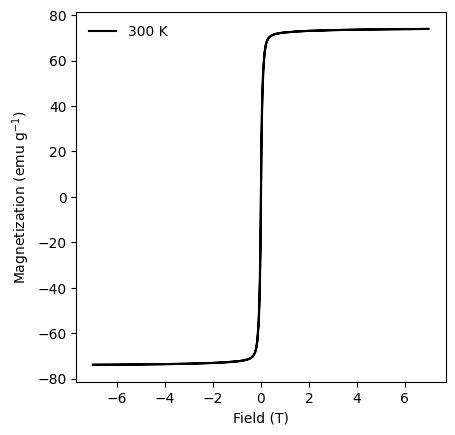

In [2]:
fig, ax = dset5.plot_mvsh()

Following the MagnetoPy `Analysis` protocol, the `CauchyCDFAnalysis` and `CauchyPDFAnalysis` classes take arguments: `dataset`, `parsing_args`, and `fitting_args`. The `parsing_args`, in general, take the arguments required to navigated the dataset and extract the specific data to be fit. In this case we'll select the M vs. H experiment at 300 K.

The `fitting_args` argument accepts either a `CauchyFittingArgs` object or an `int` representing the number of Cauchy terms to use in the fit. In a simple case like this one, simply providing the number of terms is sufficient and the automatically generated starting parameters will be close enough. 

In [3]:
nano_cauchy_cdf1 = mp.CauchyCDFAnalysis(
    dataset=dset5,
    parsing_args=mp.CauchyParsingArgs(
        temperature=300,
    ),
    fitting_args=1,
)

The results of the fit are readily plotted with the `plot()` method.

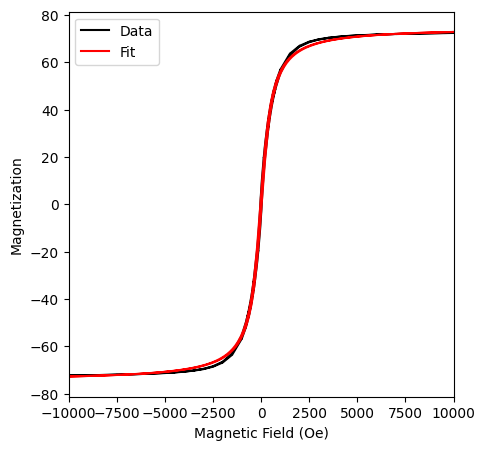

In [4]:
fig, ax = nano_cauchy_cdf1.plot()

Serialization of the `CauchyCDFAnalysis` and `CauchyPDFAnalysis` objects provides all information needed to reproduce the fit and plot.

In [5]:
print(json.dumps(nano_cauchy_cdf1.as_dict(), indent=4, default=lambda x: x.as_dict()))

{
    "_class_": "CauchyCDFAnalysis",
    "parsing_args": {
        "temperature": 300,
        "segments": "auto",
        "experiment": "MvsH",
        "_class_": "CauchyParsingArgs"
    },
    "fitting_args": {
        "_class_": "CauchyFittingArgs",
        "terms": [
            {
                "_class_": "CauchyParams",
                "m_s": [
                    73.96080646358534,
                    0,
                    110.941209695378
                ],
                "h_c": [
                    0.05078125,
                    -70000.3515625,
                    70000.453125
                ],
                "gamma": [
                    14000.08046875,
                    0,
                    140000.8046875
                ]
            }
        ]
    },
    "results": {
        "_class_": "CauchyAnalysisResults",
        "terms": [
            {
                "m_s": 75.03724020620552,
                "m_s_err": 0.11925848772738318,
                "h_c": -34.3

Note how the units of the fit are `"unknown"` by default. They can be set using the `set_units()` method of the `CauchyAnalysisResults` class.

In [6]:
nano_cauchy_cdf1.results.set_units(
    m_s="emu/g",
    h_c="Oe",
    gamma="Oe",
    chi_pd="emu/g/Oe",
)

The same process is used to fit the derivative of magnetization with respect to field to a Cauchy probability density function. The `CauchyPDFAnalysis` class is used for this purpose.

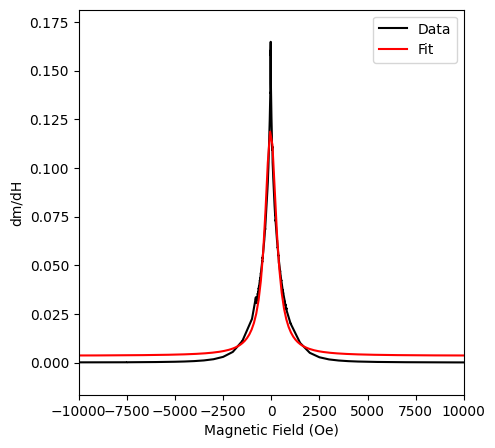

In [7]:
nano_cauchy_pdf1 = mp.CauchyPDFAnalysis(
    dataset=dset5,
    parsing_args=mp.CauchyParsingArgs(
        temperature=300,
    ),
    fitting_args=1,
)
nano_cauchy_pdf1.results.set_units(
    m_s="emu/g",
    h_c="Oe",
    gamma="Oe",
    chi_pd="emu/g/Oe",
)
fig, ax = nano_cauchy_pdf1.plot()

As was shown in the ["Datasets in MagnetoPy: The `Magnetometry` Class" example notebook](../magnetometry.ipynb), the results of the analyses can be serialized along with the rest of the dataset by adding the analyses to the `Magnetometry` object and creating a json report. [The report can be viewed here](../dataset5.json)

In [8]:
dset5.add_analysis([nano_cauchy_cdf1, nano_cauchy_pdf1])
dset5.create_report()

Report written to ..\..\tests\data\dataset5\dataset5.json


### Multi-Term Example

`"dset6"` contains M vs. H data from a single-molecule magnet described in [Orlova, et al. JACS 2023](https://pubs.acs.org/doi/full/10.1021/jacs.3c08946#). There are several temperatures and the hysteresis curves have several features that require multiple Cauchy terms to properly fit.

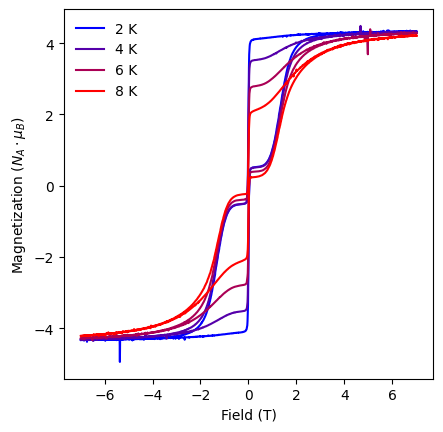

In [9]:
fig, ax = dset6.plot_mvsh(temperatures=[2,4,6,8], segment="loop")

#### Defining the Fitting Parameters

When fitting multiple terms, it is likely that you'll need to give starting values and bounds for each term rather than simply requesting a certain number of terms. This is done by passing a `CauchyFittingArgs` object to the `fitting_args` argument of the `CauchyCDFAnalysis` and `CauchyPDFAnalysis` classes.

Here we'll create some `fitting_args` that will be used for both the CDF and PDF analyses. The values are taken from the json file created by multi_cauchy when doing the initial analysis of compound 3 from the paper and published in the paper's corresponding [Zenodo entry](https://zenodo.org/records/8322969). Since multi_cauchy worked on normalized data, we'll also scale the `m_s` values by the maximum value of the data.

In [10]:
fitting_args = mp.CauchyFittingArgs(
    [
        mp.CauchyParams(
            m_s=(0.05, 0.0001, 0.3),
            h_c=(-20000, -60000, -5000),
            gamma=(25000, 5000, 200000)
        ),
        mp.CauchyParams(
            m_s=(0.5, 0, 1.0),
            h_c=(0, -100, 100),
            gamma=(100, 5, 1000)
        ),
        mp.CauchyParams(
            m_s=(0.5, 0, 1),
            h_c=(15000, 10000, 30000),
            gamma=(10000, 2500, 40000)
        )
    ]
)
m_sat = dset6.get_mvsh(2).simplified_data()['moment'].max()
for arg in fitting_args.terms:
    arg.m_s = (m_sat * arg.m_s[0], m_sat * arg.m_s[1], m_sat * arg.m_s[2])

Now we proceed as before, but pass the `CauchyFittingArgs` object as the `fitting_args` argument. Note the optional argument in the `plot()` method that allows us to plot the individual terms of the fit.

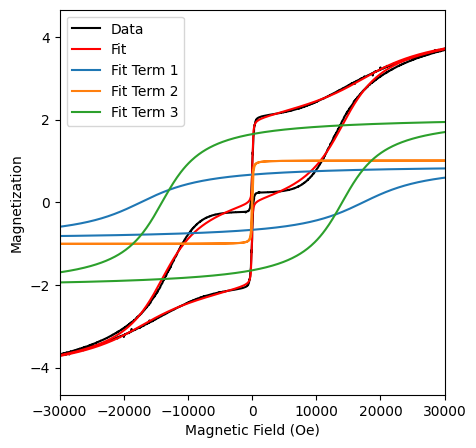

In [11]:
smm_cauchy_cdf1 = mp.CauchyCDFAnalysis(
    dataset=dset6,
    parsing_args=mp.CauchyParsingArgs(
        temperature=8,
    ),
    fitting_args=fitting_args,
)
fig, ax = smm_cauchy_cdf1.plot(
    show_full_fit=True,
    show_fit_components=True,
    xlim=[-30000, 30000],
)

And now for the `CaucyPDFAnalysis` class:

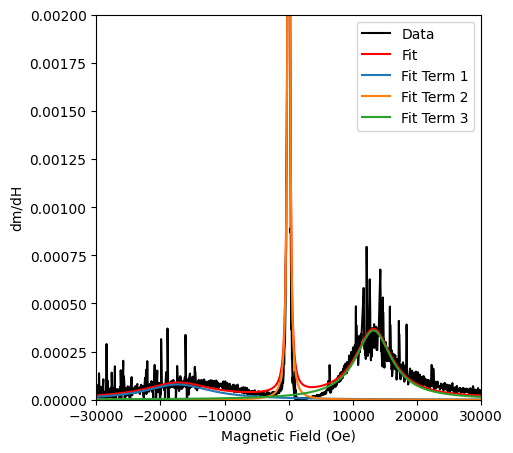

In [12]:
smm_cauchy_pdf1 = mp.CauchyPDFAnalysis(
    dataset=dset6,
    parsing_args=mp.CauchyParsingArgs(
        temperature=8,
    ),
    fitting_args=fitting_args,
)
fig, ax = smm_cauchy_pdf1.plot(
    show_full_fit=True,
    show_fit_components=True,
    xlim=[-30000, 30000],
    ylim=[0, 0.002]
)

### Analysis of Full Datasets

We'll now briefly show the utility of working with MagnetoPy-compatible classes by analyzing the full `Magnetometry` object and reproduce the analysis shown in Figure 3 (top) of the paper. The following cell goes through the full process from reading the data to plotting the results.

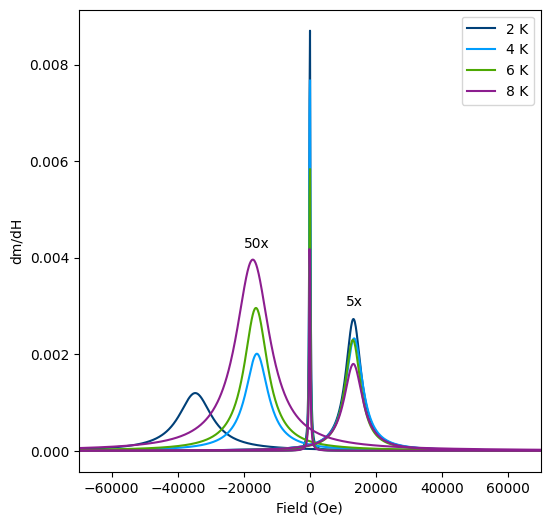

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import magnetopy as mp

# read files into a `Magnetometry` object
dset6 = mp.Magnetometry(Path("../../tests/data/dataset6"))

# define the starting values and bounds for each term
fitting_args = mp.CauchyFittingArgs(
    [
        mp.CauchyParams(
            m_s=(0.05, 0.0001, 0.3),
            h_c=(-20000, -60000, -5000),
            gamma=(25000, 5000, 200000)
        ),
        mp.CauchyParams(
            m_s=(0.5, 0, 1.0),
            h_c=(0, -100, 100),
            gamma=(100, 5, 1000)
        ),
        mp.CauchyParams(
            m_s=(0.5, 0, 1),
            h_c=(15000, 10000, 30000),
            gamma=(10000, 2500, 40000)
        )
    ]
)
m_sat = dset6.get_mvsh(2).simplified_data()['moment'].max()
for arg in fitting_args.terms:
    arg.m_s = (m_sat * arg.m_s[0], m_sat * arg.m_s[1], m_sat * arg.m_s[2])

# perform and record analyses
cdf_analyses: list[mp.CauchyCDFAnalysis] = []
pdf_analyses: list[mp.CauchyPDFAnalysis] = []
for temp in [2, 4, 6, 8]:
    cdf =  mp.CauchyCDFAnalysis(
            dataset=dset6,
            parsing_args=mp.CauchyParsingArgs(
                temperature=temp,
            ),
            fitting_args=fitting_args,
        )
    cdf.results.set_units(
        m_s="bohr_magneton",
        h_c="Oe",
        gamma="Oe",
        chi_pd="bohr_magneton/Oe",
    )
    cdf_analyses.append(cdf)
    pdf = mp.CauchyPDFAnalysis(
            dataset=dset6,
            parsing_args=mp.CauchyParsingArgs(
                temperature=temp,
            ),
            fitting_args=fitting_args,
        )
    pdf.results.set_units(
        m_s="bohr_magneton",
        h_c="Oe",
        gamma="Oe",
        chi_pd="bohr_magneton/Oe",
    )
    pdf_analyses.append(pdf)

#visualize the contribution from each term at each temperature
fig, ax = plt.subplots(figsize=(6,6))
colors = ["#004078", "#009DFD", "#4DA803", "#8C1E8F"]
labels = [2, 4, 6, 8]
x_sim = np.linspace(-70000, 70000, 1000)
for i, analysis in enumerate(pdf_analyses):
    simulated_data = analysis.results.generate_data_by_term(x_sim, "pdf")
    ax.plot(x_sim, simulated_data[0]*50, color=colors[i], label=f"{labels[i]} K")
    ax.plot(x_sim, simulated_data[1], color=colors[i])
    ax.plot(x_sim, simulated_data[2]*5, color=colors[i])
ax.legend()
ax.text(-20000, 0.0042, '50x')
ax.text(11000, 0.003, '5x')
ax.set_xlim(-70000, 70000)
ax.set_ylabel("dm/dH")
ax.set_xlabel("Field (Oe)")
mp.force_aspect(ax)


#### Serializing the Results

As before, the results of the analysis can be incorporated into the original `Magnetometry` object and serialized to a json file. [The report can be viewed here](../dataset6.json).

In [14]:
dset6.add_analysis(cdf_analyses)
dset6.add_analysis(pdf_analyses)
dset6.create_report(".")

Report written to dataset6.json


## Working with Non-MagnetoPy-compatible Data

The following section repeats the work above but using the `fit_cauchy_cdf` and `fit_cauchy_pdf` functions. These functions are available in the event that your data does not conform to the `Magnetometry` and `MvsH` classes in MagnetoPy. Ultiamtely these functions only require `x` and `y` data, along with the number of terms to fit or a `CauchyFittingArgs` object.

### Single-Term Example

Here is the same data as above -- a 300 K M vs. H dataset of a magnetite nanoparticle from [Kirkpatrick, et al. Chem. Sci. 2023](https://pubs.rsc.org/en/content/articlelanding/2023/SC/D3SC02113K).

In [15]:
np_mvsh = mp.MvsH(Path("../../tests/data/dataset5/mvsh12.dat"))
np_x = np_mvsh.simplified_data(segment="forward")["field"]
np_y = np_mvsh.simplified_data(segment="forward")["moment"]

The `x` and `y` data are fed into the `fit_cauchy_cdf()` function along with the number of terms to use to fit the data, in this case 1.

In [16]:
np_cdf_results = mp.fit_cauchy_cdf(np_x, np_y, 1)

The results of the analysis can be plot using the `plot_cauchy_cdf()` function.

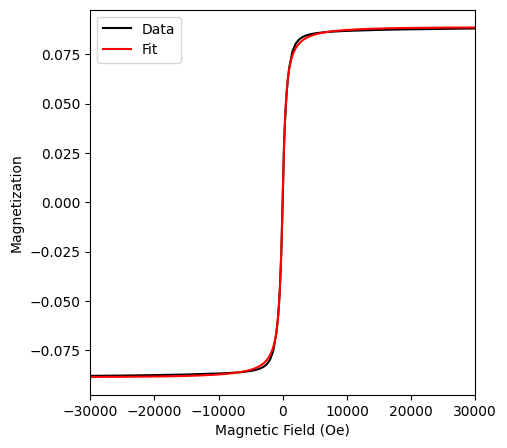

In [17]:
fig, ax = mp.plot_cauchy_cdf(
    np_x,
    np_y,
    np_cdf_results,
    show_full_fit=True,
    xlim=[-30000, 30000],
)

The `as_dict()` method can be used to help serialize the results of the analysis.

In [18]:
np_cdf_results.as_dict()

{'_class_': 'CauchyAnalysisResults',
 'terms': [{'m_s': 0.0900396924764894,
   'm_s_err': 0.00020239305755757298,
   'h_c': -34.498236180108506,
   'h_c_err': 0.9165779066552151,
   'gamma': 431.06538434181425,
   'gamma_err': 2.2297935902451087}],
 'chi_pd': -2.0820601373756488e-08,
 'chi_pd_err': 6.299151628292955e-09,
 'chi_squared': 0.0002097141224716575,
 'reduced_chi_squared': 9.575987327472944e-07,
 'm_s_unit': 'unknown',
 'h_c_unit': 'unknown',
 'gamma_unit': 'unknown',
 'chi_pd_unit': 'unknown'}

The same process can be used to fit the PDF. In this case we'll need to calculate the derivative of the data with respect to field.

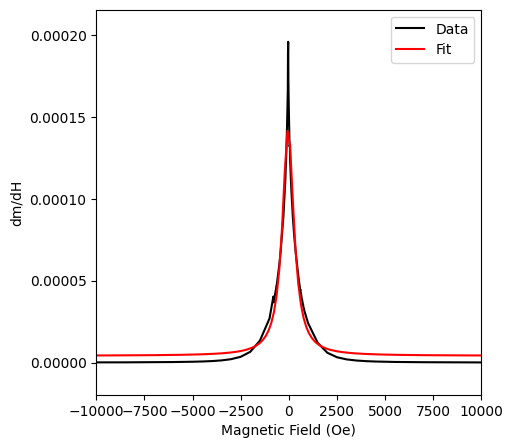

In [19]:
np_dydx = np.gradient(np_y, np_x)
np_pdf_results = mp.fit_cauchy_pdf(np_x[2:-2], np_dydx[2:-2], 1)
fig, ax = mp.plot_cauchy_pdf(
    np_x,
    np_dydx,
    np_pdf_results,
)

### Multi-Term Example

Here we'll work with the M vs. H data at 8 K that we worked with before from `"dset6"` as described in [Orlova, et al. JACS 2023](https://pubs.acs.org/doi/full/10.1021/jacs.3c08946#).

In [20]:
smm_mvsh = mp.MvsH(Path("../../tests/data/dataset6/mvsh13.dat"), temperature=8)
smm_x = smm_mvsh.simplified_data(segment="forward")["field"]
smm_y = smm_mvsh.simplified_data(segment="forward")["moment"]

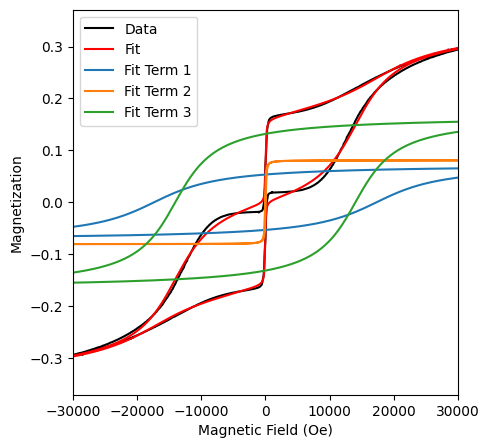

In [21]:
fitting_args = mp.CauchyFittingArgs(
    [
        mp.CauchyParams(
            m_s=(0.05, 0.0001, 0.3),
            h_c=(-20000, -60000, -5000),
            gamma=(25000, 5000, 200000)
        ),
        mp.CauchyParams(
            m_s=(0.5, 0, 1.0),
            h_c=(0, -100, 100),
            gamma=(100, 5, 1000)
        ),
        mp.CauchyParams(
            m_s=(0.5, 0, 1),
            h_c=(15000, 10000, 30000),
            gamma=(10000, 2500, 40000)
        )
    ]
)
m_sat = dset6.get_mvsh(2).simplified_data()['moment'].max()
for arg in fitting_args.terms:
    arg.m_s = (m_sat * arg.m_s[0], m_sat * arg.m_s[1], m_sat * arg.m_s[2])

# perform the fit
results = mp.fit_cauchy_cdf(smm_x, smm_y, fitting_args)

# visualize the fit
fig, ax = mp.plot_cauchy_cdf(
    smm_x,
    smm_y,
    results,
    add_reversed_data=True,
    add_reversed_simulated=True,
    show_full_fit=True,
    show_fit_components=True,
    xlim=[-30000, 30000],
)

And now the PDF. While it's not an issue in this case, it's often necessary to remove the first and last few data points from the analysis due to edge effects that arise during differentiation.

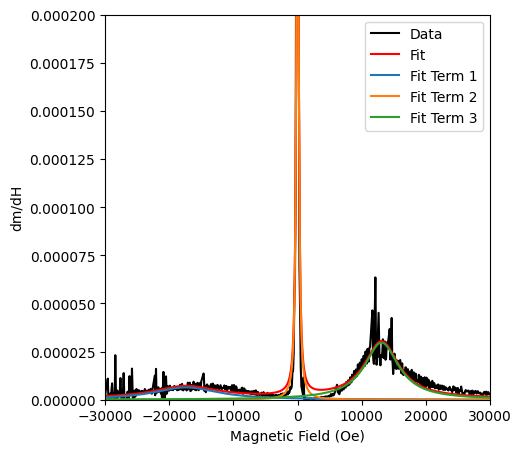

In [22]:
smm_dydx = np.gradient(smm_y, smm_x)

# perform the fit, removing the first and last two points
results = mp.fit_cauchy_pdf(smm_x[2:-2], smm_dydx[2:-2], fitting_args)

# visualize the fit
fig, ax = mp.plot_cauchy_pdf(
    smm_x,
    smm_dydx,
    results,
    show_full_fit=True,
    show_fit_components=True,
    xlim=[-30000, 30000],
    ylim=[0, 0.0002]
)